In [1]:
!rm -rf .models
!mkdir .models

In [2]:
!wget -q -O .models/cifar_nat.pt "https://www.dropbox.com/s/yhpp4yws7sgi6lj/cifar_nat.pt?dl=1"
!wget -q -O .models/cifar_linf_8.pt "https://www.dropbox.com/s/yhpp4yws7sgi6lj/cifar_linf_8.pt?dl=1"

In [1]:
import os
import pathlib
import random
import functools
import copy
import sys
import pickle
import tarfile
import operator
import math
import requests
import importlib
os.environ["NOTEBOOK_MODE"] = "1"

import tqdm
from tqdm import notebook
import cox

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn import preprocessing
import scipy

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import torch

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import flax
import neural_tangents as nt
import art
import robustness
from robustness import model_utils, datasets, train, defaults

import vit_jax

import adversarial_ntks as atk
from adversarial_ntks import dataset

f:\users\0\main\active\erlija\adversarial-ntks\robustness\robustness\train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


In [2]:
CIFAR10 = {}

In [3]:
CIFAR10.update({
    "train": atk.dataset.get_np_data(
        name="cifar10",
        split="train[:128]",
        flatten=False,
        data_dir=".data/"),
    "test": atk.dataset.get_np_data(
        name="cifar10",
        split="test[:128]",
        flatten=False,
        data_dir=".data/"),
    "dataset": robustness.datasets.CIFAR(".data"),
    "workers": 12,
    "arch": "resnet50",
    "resume_path_nat": ".models/cifar_nat.pt",
    "resume_path_linf": ".models/cifar_linf_8.pt",
    "labels": ["airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"],
    
    "batch_size": 64,

    "perturb_eps": 8/255,

    "display_samples": 10,
    "display_sample_img_size": 3})

In [4]:
def exp_load_saved(exp):
    exp["model_nat"], _ = model_utils.make_and_restore_model(
        arch=exp["arch"],
        resume_path=exp["resume_path_nat"],
        dataset=exp["dataset"])
    exp["model_linf"], _ = model_utils.make_and_restore_model(
        arch=exp["arch"],
        resume_path=exp["resume_path_linf"],
        dataset=exp["dataset"])

exp_load_saved(CIFAR10)

=> loading checkpoint '.models/cifar_nat.pt'
=> loaded checkpoint '.models/cifar_nat.pt' (epoch 190)
=> loading checkpoint '.models/cifar_linf_8.pt'
=> loaded checkpoint '.models/cifar_linf_8.pt' (epoch 190)


In [34]:
def exp_eval_ueb_atk(exp, models, dss, samples):
    c_correct = {}
    for ds in dss:
        xs_gpu = torch.Tensor(np.transpose(exp[ds].xs, (0, 3, 1, 2))).cuda()
        ys_gpu = torch.Tensor(exp[ds].ys).cuda()
        c_batches = len(exp[ds].xs) // exp["batch_size"]

        c_correct[ds] = {}
        for model in models:
            c_correct[ds][model] = []
    
        for batch_id in tqdm.notebook.tqdm(range(c_batches), desc="Batch"):
            batch_start = batch_id * exp["batch_size"]
            batch_end = batch_start + exp["batch_size"]
            batch_xs = xs_gpu[batch_start:batch_end]
            batch_ys = ys_gpu[batch_start:batch_end]

            c_correct_batch = {}
            for model in models:
                c_correct_batch[model] = []

            for sample in tqdm.notebook.tqdm(range(samples), desc="Sample"):
                xs_perturbation = (torch.rand(batch_xs.shape) * \
                    exp["perturb_eps"] * 2 - exp["perturb_eps"]).cuda()
                xs_perturbed = batch_xs.add(xs_perturbation).clamp(0, 1)

                for model in models:
                    predictions = exp[model](xs_perturbed)[0].argmax(dim=1)
                    c_correct_batch[model].append(
                        predictions.eq(batch_ys).cpu())
                        
                    del predictions

                del xs_perturbation, xs_perturbed

            for model in models:
                c_correct[ds][model].append(np.vstack(
                    c_correct_batch[model]).transpose())

        for model in models:
            c_correct[ds][model] = \
                np.concatenate(c_correct[ds][model]).astype(int)

        del xs_gpu, ys_gpu
    
    return c_correct

CIFAR10["ueb-atk-res"] = exp_eval_ueb_atk(
    CIFAR10,
    ["model_linf", "model_nat"],
    ["test", "train"],
    64)

Batch:   0%|          | 0/2 [00:00<?, ?it/s]

Sample:   0%|          | 0/4 [00:00<?, ?it/s]

Sample:   0%|          | 0/4 [00:00<?, ?it/s]

Batch:   0%|          | 0/2 [00:00<?, ?it/s]

Sample:   0%|          | 0/4 [00:00<?, ?it/s]

Sample:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-86-e52343b7672c>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-86-e52343b7672c>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


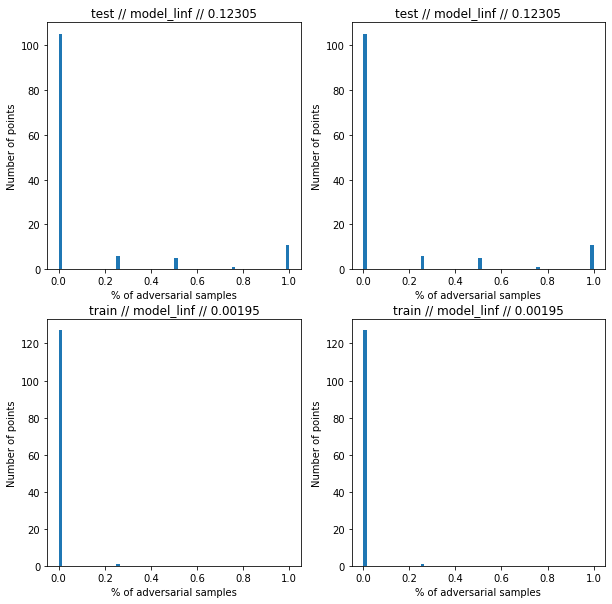

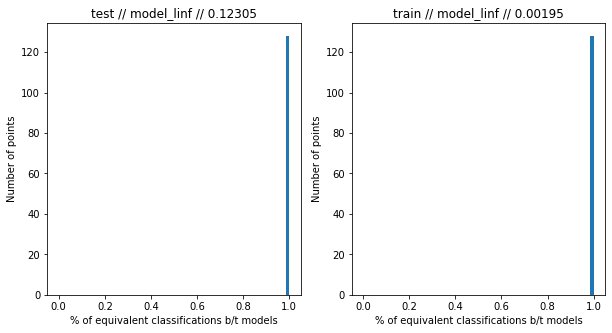

In [86]:
def exp_show_ueb_atk_res(exp):
    res = CIFAR10["ueb-atk-res"]
    dss, models = [], []
    for ds in res.keys():
        dss.append(ds)
        for model in res[ds].keys():
            models.append(model)
            break

    fig, ax = plt.subplots(len(dss), len(models), figsize=(5 * len(dss), 5 * len(models)))
    fig2, ax2 = plt.subplots(1, len(dss), figsize=(5 * len(dss), 5))
    for ds_i in range(len(dss)):
        ds = dss[ds_i]
        for model_i in range(len(models)):
            model = models[model_i]
            cur_ax = ax if type(ax) is not np.ndarray else (
                ax[ds_i] if type(ax[ds_i]) is not np.ndarray else
                    ax[ds_i][model_i])
            uebp = 1 - \
                np.sum(res[ds][model], axis=1) / res[ds][model].shape[1]
            cur_ax.hist(uebp, bins=64, range=(0, 1))
            cur_ax.set_title(ds + " // " + model + " // {:.5f}".format(1 - res[ds][model].mean()))
            cur_ax.set_xlabel("% of adversarial samples")
            cur_ax.set_ylabel("Number of points")

        if len(models) == 2:
            res1, res2 = res[ds][models[0]], res[ds][models[1]]
            eval_equal = res1 == res2
            overlap = np.sum(eval_equal, axis=1) / res1.shape[1]
            ax2[ds_i].hist(overlap, bins=64, range=(0, 1))
            ax2[ds_i].set_title(ds + " // " + model + " // {:.5f}".format(1 - res[ds][model].mean()))
            ax2[ds_i].set_xlabel("% of equivalent classifications b/t models")
            ax2[ds_i].set_ylabel("Number of points")

    fig.show()
    fig2.show()

exp_show_ueb_atk_res(CIFAR10)